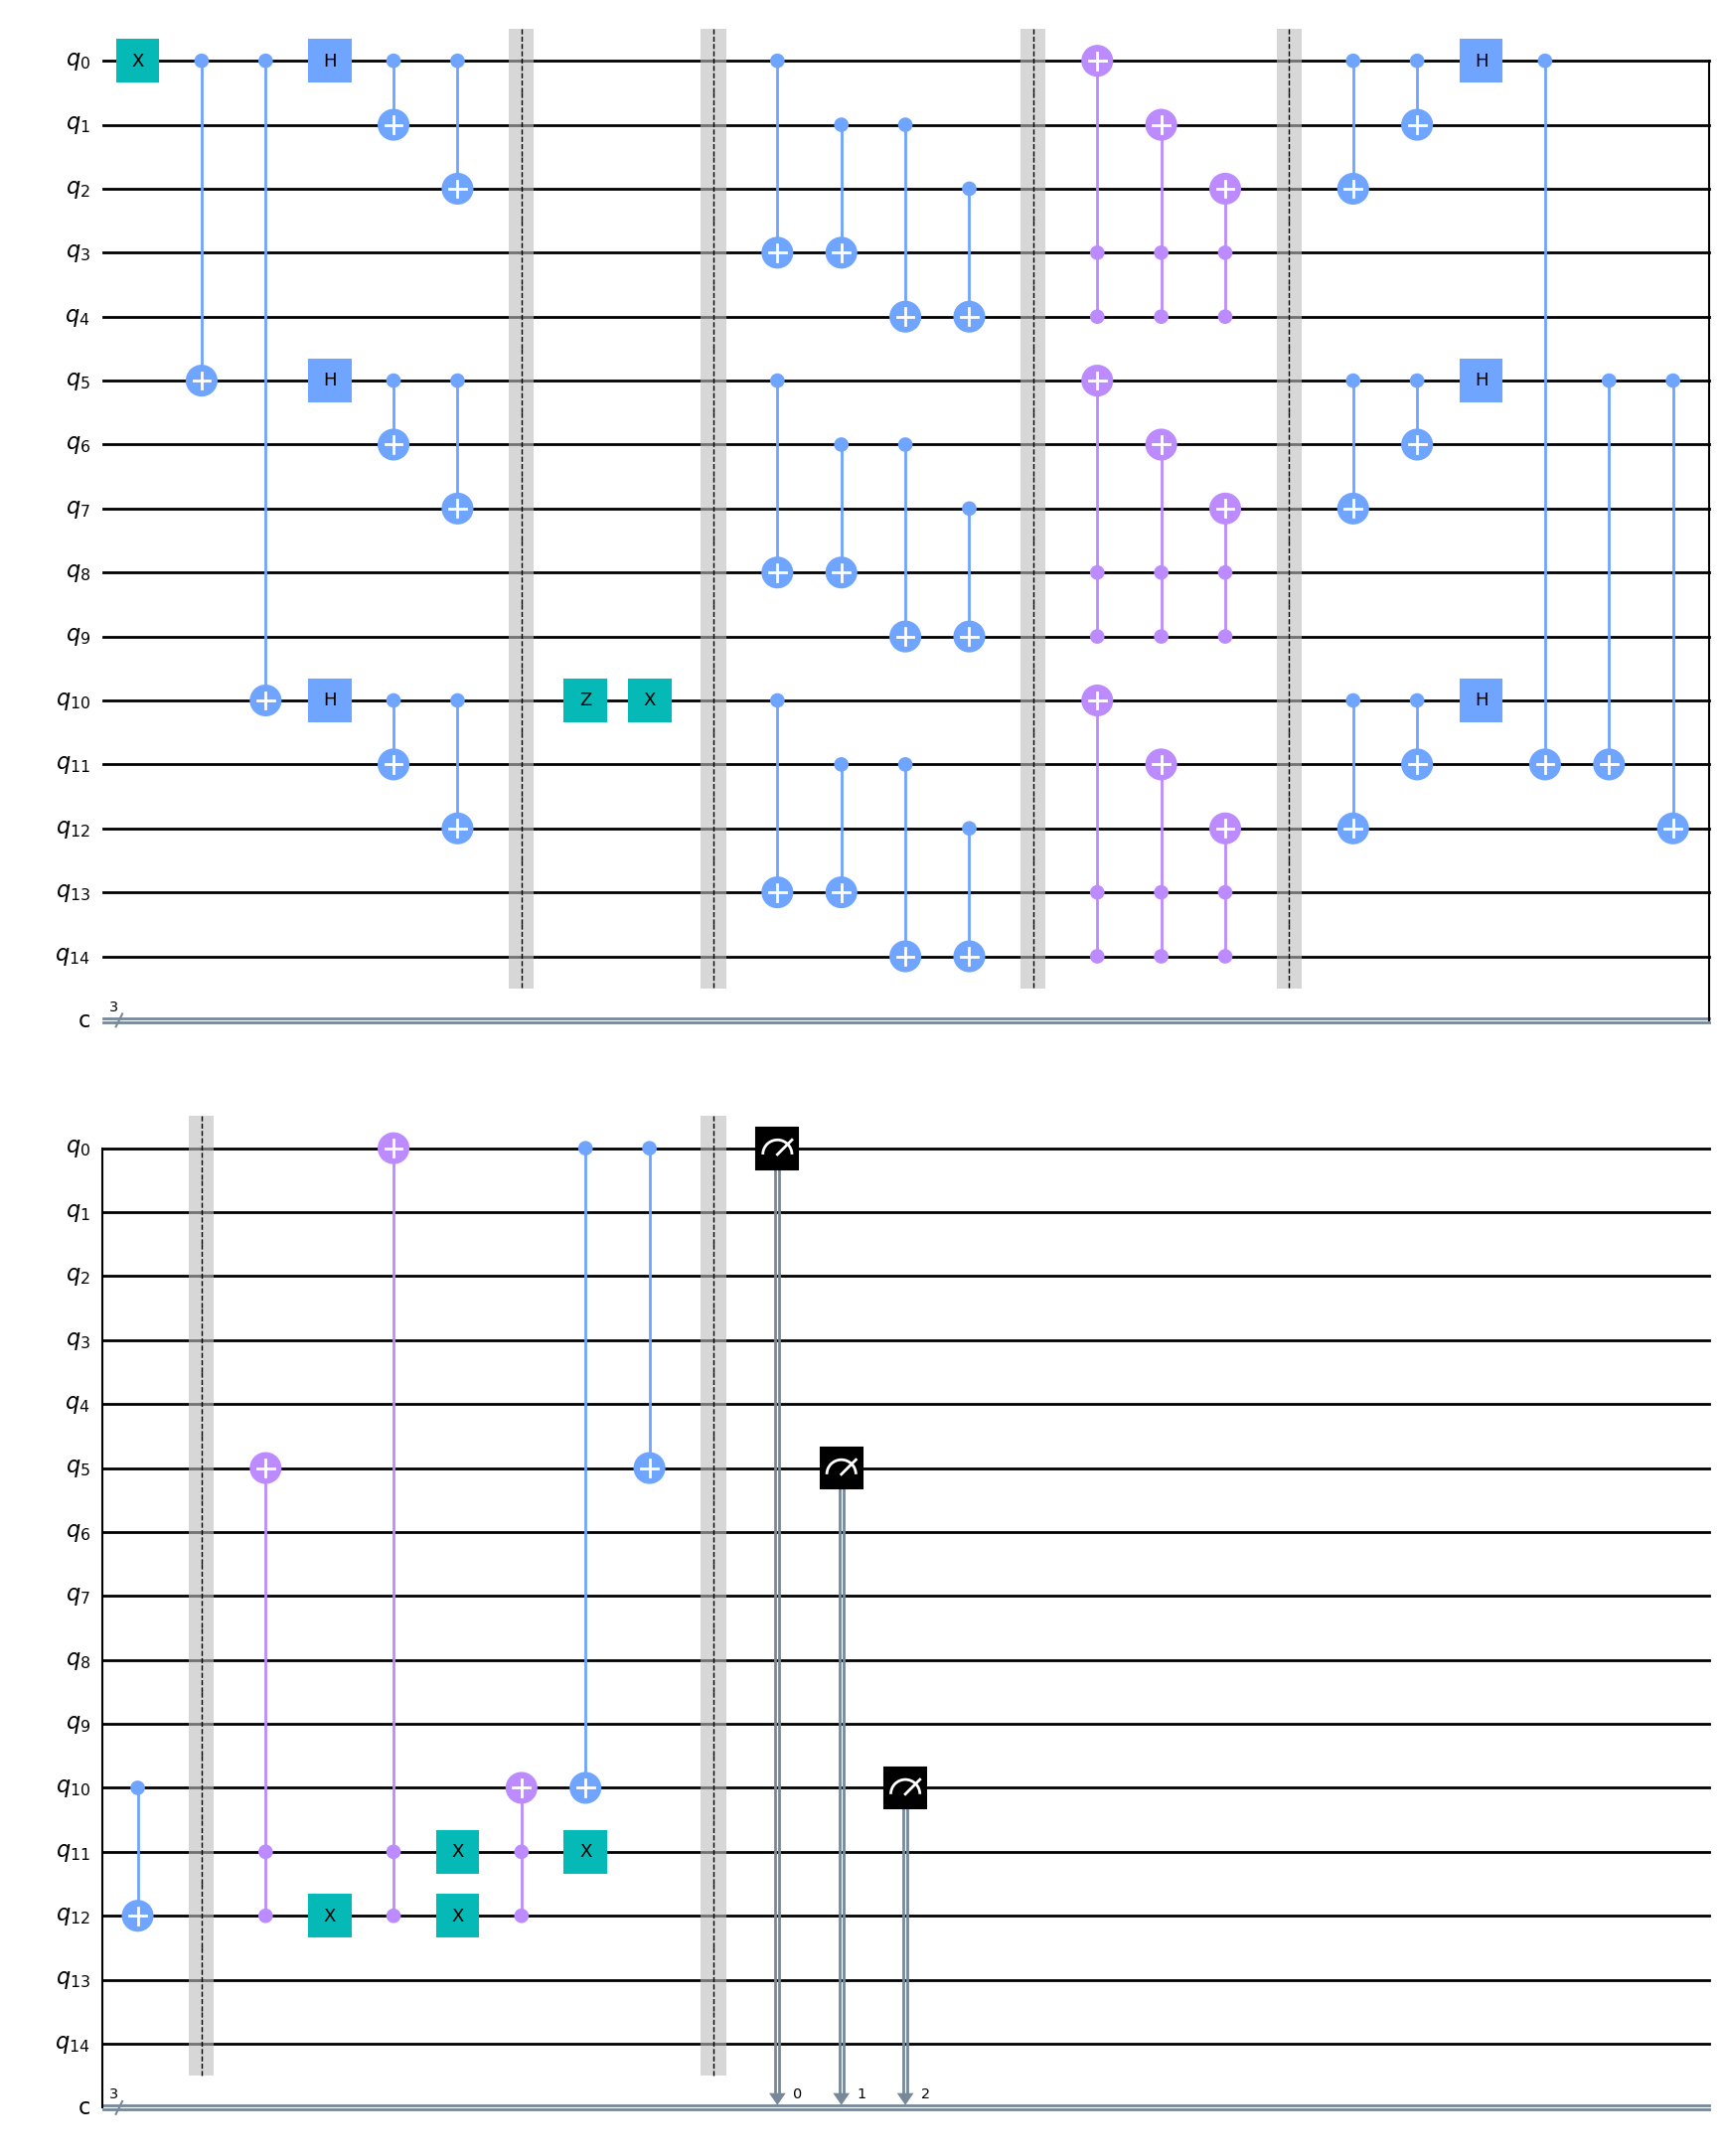

In [31]:
import numpy as np
from qiskit import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Method to generate noise model
def get_noise(p_meas, p_gate):
    error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_model

# Initiating quantum and classical registers
qreg_q = QuantumRegister(15, 'q')
creg_c = ClassicalRegister(3, 'c')

# Initiating circuit
circuit = QuantumCircuit(qreg_q, creg_c)

# Encoding the circuit
circuit.x(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[5])
circuit.cx(qreg_q[0], qreg_q[10])

circuit.h(qreg_q[0])
circuit.h(qreg_q[5])
circuit.h(qreg_q[10])

circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[5], qreg_q[6])
circuit.cx(qreg_q[10], qreg_q[11])
circuit.cx(qreg_q[5], qreg_q[7])
circuit.cx(qreg_q[10], qreg_q[12])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.barrier()

# Simulating flip error
circuit.z(qreg_q[10])
circuit.x(qreg_q[10])
circuit.barrier()

# Phase-flip error detection circuit
circuit.cx(qreg_q[0], qreg_q[3])
circuit.cx(qreg_q[5], qreg_q[8])
circuit.cx(qreg_q[10], qreg_q[13])

circuit.cx(qreg_q[11], qreg_q[13])
circuit.cx(qreg_q[6], qreg_q[8])
circuit.cx(qreg_q[1], qreg_q[3])

circuit.cx(qreg_q[11], qreg_q[14])
circuit.cx(qreg_q[6], qreg_q[9])
circuit.cx(qreg_q[1], qreg_q[4])
circuit.cx(qreg_q[12], qreg_q[14])
circuit.cx(qreg_q[7], qreg_q[9])
circuit.cx(qreg_q[2], qreg_q[4])

# Recovery circuit for phase-flip
circuit.barrier()
circuit.ccx(qreg_q[14], qreg_q[13], qreg_q[10])
circuit.ccx(qreg_q[9], qreg_q[8], qreg_q[5])
circuit.ccx(qreg_q[4], qreg_q[3], qreg_q[0])

circuit.ccx(qreg_q[14], qreg_q[13], qreg_q[11])
circuit.ccx(qreg_q[9], qreg_q[8], qreg_q[6])
circuit.ccx(qreg_q[4], qreg_q[3], qreg_q[1])

circuit.ccx(qreg_q[14], qreg_q[13], qreg_q[12])
circuit.ccx(qreg_q[9], qreg_q[8], qreg_q[7])
circuit.ccx(qreg_q[4], qreg_q[3], qreg_q[2])

# Bit-flip error detection circuit
circuit.barrier()
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[5], qreg_q[7])
circuit.cx(qreg_q[10], qreg_q[12])

circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[5], qreg_q[6])
circuit.cx(qreg_q[10], qreg_q[11])

circuit.h(qreg_q[0])
circuit.h(qreg_q[5])
circuit.h(qreg_q[10])

circuit.cx(qreg_q[0], qreg_q[11])
circuit.cx(qreg_q[5], qreg_q[11])
circuit.cx(qreg_q[5], qreg_q[12])
circuit.cx(qreg_q[10], qreg_q[12])

# Recovery circuit for bit-flip
circuit.barrier()
circuit.ccx(qreg_q[12], qreg_q[11], qreg_q[5])
circuit.x(qreg_q[12])
circuit.ccx(qreg_q[12], qreg_q[11], qreg_q[0])
circuit.x(qreg_q[12])
circuit.x(qreg_q[11])
circuit.ccx(qreg_q[12], qreg_q[11], qreg_q[10])
circuit.x(qreg_q[11])
circuit.cx(qreg_q[0], qreg_q[10])
circuit.cx(qreg_q[0], qreg_q[5])

# Measurement
circuit.barrier()
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[5], creg_c[1])
circuit.measure(qreg_q[10], creg_c[2])

# Display circuit diagram
circuit.draw(output='mpl')

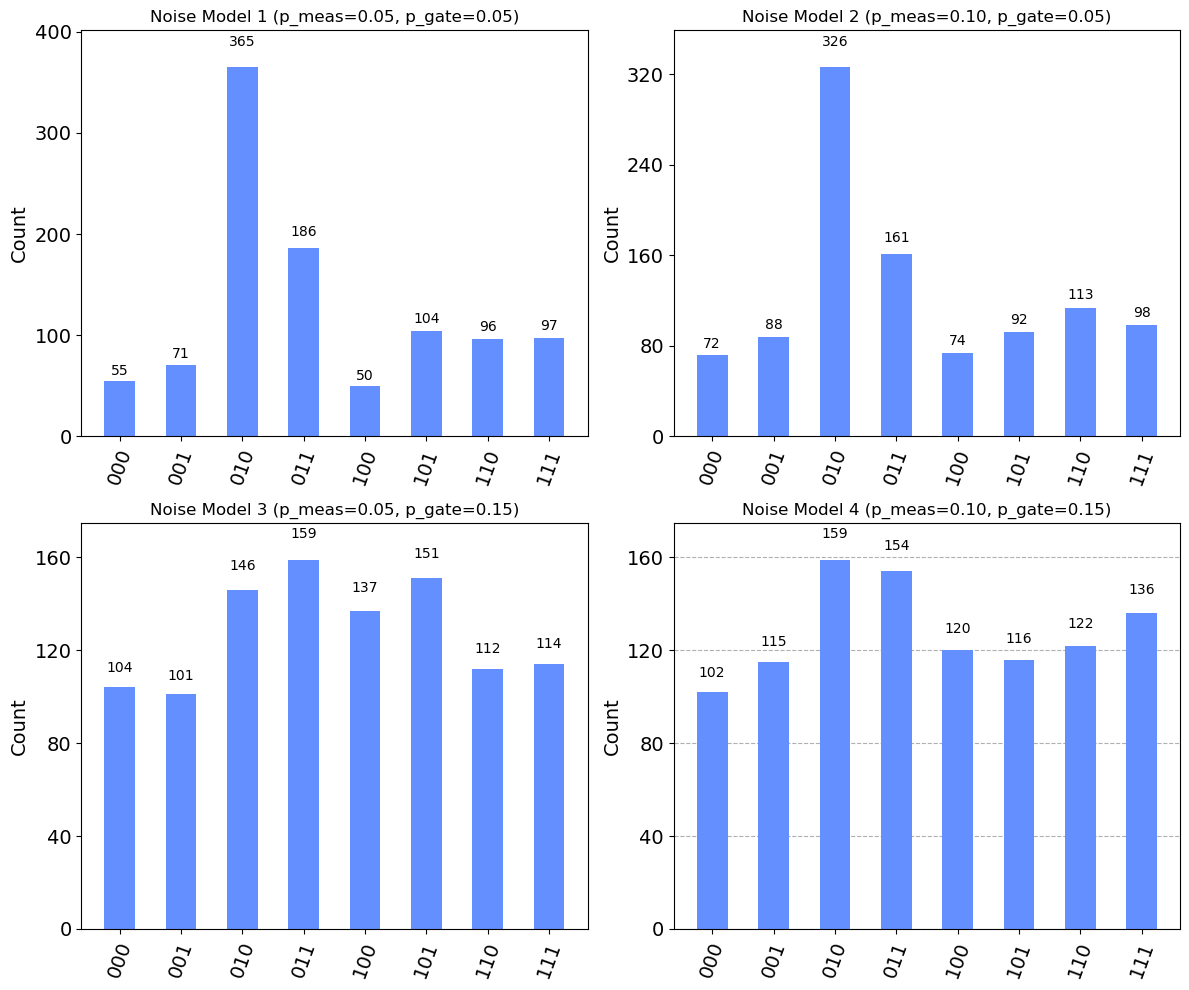

In [32]:
# Execute the circuit with different noise models
noise_model1 = get_noise(0.05, 0.05)
noise_model2 = get_noise(0.10, 0.05)
noise_model3 = get_noise(0.05, 0.15)
noise_model4 = get_noise(0.10, 0.15)
backend = Aer.get_backend('qasm_simulator')     

job1 = execute(circuit, backend, noise_model=noise_model1, shots=1024)
job2 = execute(circuit, backend, noise_model=noise_model2, shots=1024)
job3 = execute(circuit, backend, noise_model=noise_model3, shots=1024)
job4 = execute(circuit, backend, noise_model=noise_model4, shots=1024)

result1 = job1.result()
result2 = job2.result()
result3 = job3.result()
result4 = job4.result()

# Get counts
counts1 = result1.get_counts(circuit)
counts2 = result2.get_counts(circuit)
counts3 = result3.get_counts(circuit)
counts4 = result4.get_counts(circuit)

# Plot histograms side by side
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_histogram(counts1, ax=axs[0, 0])
axs[0, 0].set_title('Noise Model 1 (p_meas=0.05, p_gate=0.05)')

plot_histogram(counts2, ax=axs[0, 1])
axs[0, 1].set_title('Noise Model 2 (p_meas=0.10, p_gate=0.05)')

plot_histogram(counts3, ax=axs[1, 0])
axs[1, 0].set_title('Noise Model 3 (p_meas=0.05, p_gate=0.15)')

plot_histogram(counts4, ax=axs[1, 1])
axs[1, 1].set_title('Noise Model 4 (p_meas=0.10, p_gate=0.15)')

plt.tight_layout()
plt.show()